In [3]:
import sys
sys.path.append('/home/github/Climatology')
import climsy as cs
#import newBlock as nb
import cartopy
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
#import metpy.calc as mpcalc
import json
import calendar
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 

import matplotlib.ticker as mticker
import matplotlib.font_manager as font_manager
import matplotlib.patches as mpatches
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

%matplotlib inline

from netCDF4 import num2date

# Coords

In [8]:
usin = pd.read_csv('/home/data/csv/vazao/Usinas-MODCLIM.csv')

dropped = usin.drop(['PROPRIETAR', 'CNPJ', 'TIPO', 'CEG', 'MUNIC_CF', 'UF_CF',
       'MUNIC_1', 'UF_1', 'MUNIC_2', 'UF_2', 'RIO', 'COD_BAC', 'COD_SBAC',
       'DSP_INV', 'ATO_LEGAL', 'PROC_ANEEL','POT_KW', 'N_UNID_GER', 'POT_UNI_GE',
       'FATOR_POT', 'POT_POR_TU', 'ENG_MIN', 'TIPO_TURB', 'REND_NOM_T',
       'REND_NOM_G', 'TX_EQ_INDS', 'INDS_PROG', 'PERD_HID_N', 'NA_MAX_MAX',
       'NA_MAX_MON', 'NA_MIN_MON', 'NA_NOR_JUS', 'AREA_NA_MA', 'AREA_NA_MI',
       'AREA_DREN', 'VOL_NA_MAX', 'VOL_NA_MIN', 'REGUL_MEN', 'QD_BRUTA_N',
       'PERDAS_ELE', 'CONS_INTER', 'VAZAO_REM', 'VAZAO_USO_', 'VAZAO_PROJ',
       'SERIE_VAZA', 'TABELA_SER', 'OBS', 'DATA_ATUAL', 'REN_696_15',
       'ESTAGIO', 'INIC_OPER', 'POT_FISC_K', 'COD_UPH', 'ID_EMPREEN', 'VERSAO', 'ESTAGIO_1', 'Regulariza','LAT_EIXO_G','LONG_EIXO_','LAT_CF_GMS','LONG_CF_GM'], axis=1).set_index('NOME')

final_U = dropped.drop(['Água Vermelha', 'Salto Osório'], axis=0)

In [23]:
def process(time):
    dataset2 = cs.open_dataset('/home/data/netcdf/msl_70_20_largeCut.nc')
    dados2 = (dataset2.fit(lon=[-65,20], lat=[-10,-50], time=time, opr="/", factor=100)).dataset
    data_season = dados2.sel(time=slice("1979-12-01", "2018-11-01")).groupby('time.season').mean()
    data = data_season.where(data_season.msl>=1017.99)
    
    dataDJF = data.sel(season='DJF').dropna(dim='lon',how='all').dropna(dim='lat',how='all')
    dataJJA = data.sel(season='JJA').dropna(dim='lon',how='all').dropna(dim='lat',how='all')
    dataMAM = data.sel(season='MAM').dropna(dim='lon',how='all').dropna(dim='lat',how='all')
    dataSON = data.sel(season='SON').dropna(dim='lon',how='all').dropna(dim='lat',how='all')
    
    DJF_coords_min = [dataDJF.msl.lon.values.min(), dataDJF.msl.lat.values.min()]
    DJF_coords_max = [dataDJF.msl.lon.values.max(), dataDJF.msl.lat.values.max()]

    JJA_coords_min = [dataJJA.msl.lon.values.min(), dataJJA.msl.lat.values.min()]
    JJA_coords_max = [dataJJA.msl.lon.values.max(), dataJJA.msl.lat.values.max()]

    MAM_coords_min = [dataMAM.msl.lon.values.min(), dataMAM.msl.lat.values.min()]
    MAM_coords_max = [dataMAM.msl.lon.values.max(), dataMAM.msl.lat.values.max()]

    SON_coords_min = [dataSON.msl.lon.values.min(), dataSON.msl.lat.values.min()]
    SON_coords_max = [dataSON.msl.lon.values.max(), dataSON.msl.lat.values.max()]
    
    return data, DJF_coords_min, DJF_coords_max, JJA_coords_min, JJA_coords_max, MAM_coords_min, MAM_coords_max ,SON_coords_min ,SON_coords_max

In [24]:
def figura(time, plot_type='contourf'):#, DJF_coords_min, DJF_coords_max, JJA_coords_min, JJA_coords_max, MAM_coords_min, MAM_coords_max ,SON_coords_min ,SON_coords_max):
    fig, ax = plt.subplots(nrows=2,ncols=2,subplot_kw=dict(projection = ccrs.PlateCarree()), figsize=(32,18))
    plt.subplots_adjust(hspace = 0.15, wspace= 0.0005)
    fig.suptitle('Mean Sea Level Pressure by Season',  fontsize=29, weight="medium", ha="center")				
    
    data, DJF_coords_min, DJF_coords_max, JJA_coords_min, JJA_coords_max, MAM_coords_min, MAM_coords_max ,SON_coords_min ,SON_coords_max = process(time)
    
    plott(ax[0][0], plot_type, 'DJF', data, DJF_coords_min, DJF_coords_max)
    plott(ax[0][1], plot_type, 'JJA', data, JJA_coords_min, JJA_coords_max)
    plott(ax[1][0], plot_type, 'MAM', data, MAM_coords_min, MAM_coords_max)
    plott(ax[1][1], plot_type, 'SON', data, SON_coords_min ,SON_coords_max)

    fig.tight_layout()

In [27]:
def plott(ax, plot_type, season, data, season_coords_min, season_coords_max):
    
    clevs_ = np.arange(1018,1026,1)
    
    if plot_type == 'contourf':
        cf = ax.contourf(data.lon.values, data.lat.values, data.msl.sel(season=season), clevs_, extend='both', cmap='YlGnBu_r')
        cbar = plt.colorbar(cf, orientation='horizontal', pad=0.10 , ax=ax, shrink = 0.68, aspect=40)
        cbar.ax.tick_params(labelsize=20)
        #cbar.set_label("W / m²", fontsize = 17, y = 0.3)
    
    elif plot_type == 'contour':
        cf = ax.contour(data.lon.values, data.lat.values, data.msl.sel(season=season), clevs_, colors='k' )
        ax.clabel(cf, inline_spacing=7, fontsize= 10, fmt = '%1.0f')

    seasonDATA = data.sel(season=season)
    maxPT = seasonDATA.where(seasonDATA.msl==seasonDATA.msl.max(), drop=True)
    ax.scatter(final_U['LONG_EIXO1'], final_U['LAT_EIXO_D'], transform=ccrs.PlateCarree(), color='orangered', alpha=1, marker='x')
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='black', alpha=0.3, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.ylines = True
    gl.xlines = True
    #gl.xlocator = mticker.FixedLocator(np.arange(-70, 50, 20)) #-70,50,20
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    
    ax.coastlines('50m')
    #ax.get_extent
    ax.set_extent([-70, 18, -42, 0])
    ax.set_title('LAMMOC-UFF', fontdict={'fontsize': 17}, loc = 'right', style="oblique")
    ax.set_title(season, fontdict={'fontsize': 30}, loc = 'left', style="oblique")
   
    #ax.add_feature(cartopy.feature.LAND)
    #ax.add_feature(cartopy.feature.OCEAN)
    #ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='gray')
    ax.stock_img()
    
    line = plt.Line2D((season_coords_min[0],season_coords_min[0]), (season_coords_min[1],season_coords_max[1]),linewidth=4, color = 'midnightblue')
    ax.add_line(line)
    line2 = plt.Line2D((season_coords_min[0],season_coords_max[0]), (season_coords_max[1],season_coords_max[1]),linewidth=4, color = 'midnightblue')
    ax.add_line(line2)
    line3 = plt.Line2D((season_coords_max[0],season_coords_max[0]), (season_coords_max[1],season_coords_min[1]),linewidth=4, color = 'midnightblue')
    ax.add_line(line3)
    line4 = plt.Line2D((season_coords_max[0],season_coords_min[0]), (season_coords_min[1],season_coords_min[1]),linewidth=4, color = 'midnightblue')
    ax.add_line(line4)


/home/gabriel/miniconda3/envs/bloqueios/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/gabriel/miniconda3/envs/bloqueios/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/gabriel/miniconda3/envs/bloqueios/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/gabriel/miniconda3/envs/bloqueios/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_

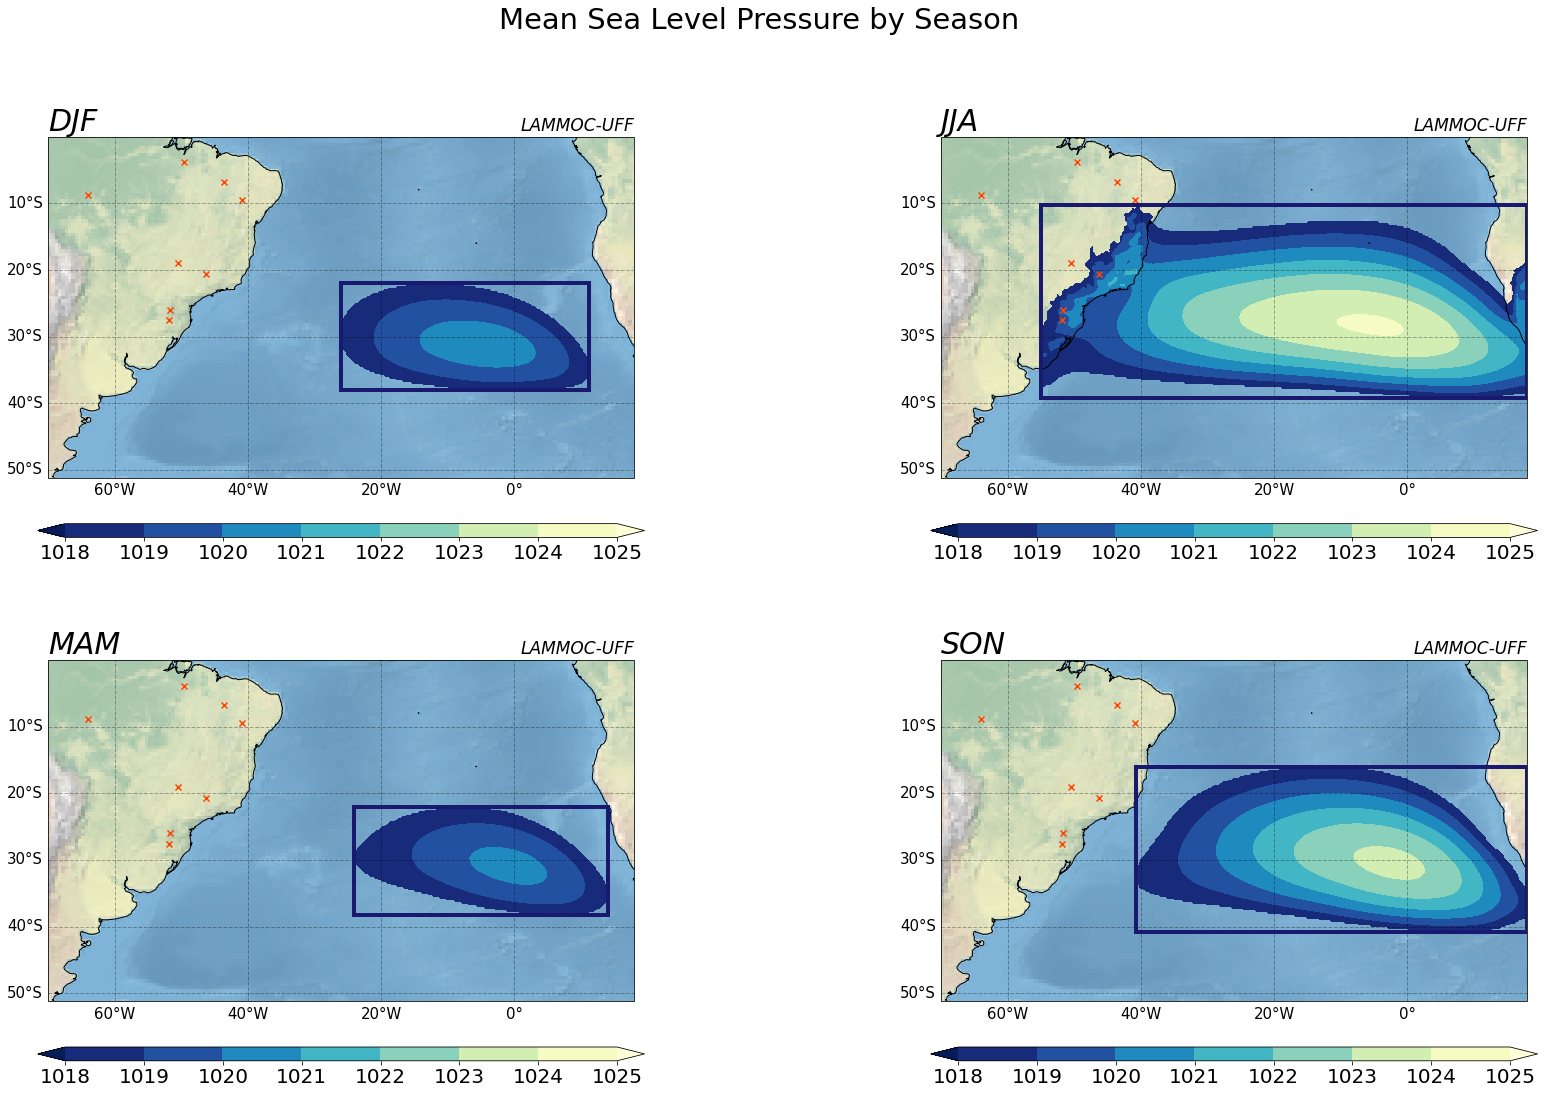

In [28]:
figura(time=["1979-12-01", "2020-12-01"], plot_type='contourf')
plt.savefig("/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/Apresentações/MODCLIM2/area_msl", bbox_inches = 'tight')

# Vazões

In [4]:
usi_list = ['furnas', 'sao_simao', 'g_b_munhoz', 'passo_real', 'sobradinho', 'b_esperanca', 'tucurui', 'santo_antonio']

In [5]:
vazoes0 = pd.read_pickle('/home/data/csv/vazoes_diarias_1969_2019_preenchido.pkl')
vazoes0

,14_de_julho,a_vermelha,a_a_laydner,a_dias_s_car,a_s_lima,a_s_oliveira,aimores,alto_tiete,anta,b_coqueiros,...,sta_cecilia,sta_clara_mg,sta_clara_pr,taquarucu,tocos,tres_irmaos,tres_marias,tucurui,volta_grande,xingo
data,,,,,,,,,,,,,,,,,,,,,
1969-01-01,67.96,1538.0,112.00,63.00,287.0,39.0,624.00,5.0,417.00,-8.780103,...,218.00,98.00,45.00,661.00,6.00,951.889173,1058.0,14944.893828,979.0,4829.0
1969-01-02,55.75,1557.0,113.00,59.00,272.0,31.0,589.00,4.0,411.00,-6.981520,...,232.00,95.00,40.00,601.00,5.00,975.239993,1070.0,15160.348695,944.0,5183.0
1969-01-03,50.47,1531.0,149.00,55.00,223.0,28.0,556.00,4.0,401.00,-5.239042,...,245.00,92.00,47.00,529.00,6.00,999.207185,968.0,15374.025964,914.0,4983.0
1969-01-04,68.97,1475.0,108.00,57.00,211.0,26.0,527.00,4.0,407.00,-3.540863,...,243.00,85.00,60.00,491.00,9.00,1023.598017,831.0,15585.543217,906.0,4836.0
1969-01-05,124.40,1426.0,132.00,51.00,217.0,27.0,509.00,5.0,423.00,-1.874349,...,235.00,84.00,75.00,483.00,7.00,1048.208731,745.0,15794.564439,902.0,4640.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,37.90,1869.0,210.40,56.42,549.0,64.0,409.62,4.0,617.75,187.000000,...,270.12,6.93,59.95,1062.57,10.34,648.000000,644.0,3581.000000,1113.0,2725.0
2019-12-28,34.75,1861.0,184.78,48.82,373.0,53.0,394.12,4.0,496.77,184.000000,...,216.04,7.75,55.07,924.17,9.62,711.000000,750.0,3625.000000,1170.0,2640.0
2019-12-29,33.17,1866.0,151.21,42.09,292.0,47.0,382.58,4.0,452.05,179.000000,...,201.60,8.56,51.32,817.85,8.85,827.000000,752.0,3729.000000,1159.0,2484.0


In [6]:
df_list = []
for cada in usi_list:
    df = pd.DataFrame(vazoes0[cada])
    df_list.append(df)
VZ_69_19 = pd.concat([df_list[0],df_list[1], df_list[2],df_list[3],df_list[4],df_list[5],df_list[6],df_list[7]], axis=1)

In [7]:
VZ_69_19

,furnas,sao_simao,g_b_munhoz,passo_real,sobradinho,b_esperanca,tucurui,santo_antonio
data,,,,,,,,
1969-01-01,687.0,2636.0,435.00,72.00,4237.0,557.0,14944.893828,20664.00
1969-01-02,721.0,2462.0,413.00,88.00,4161.0,655.0,15160.348695,20917.00
1969-01-03,728.0,2263.0,404.00,83.00,4087.0,675.0,15374.025964,20805.00
1969-01-04,681.0,2064.0,404.00,90.00,3963.0,608.0,15585.543217,20418.00
1969-01-05,638.0,1846.0,413.00,184.00,3804.0,546.0,15794.564439,20042.00
...,...,...,...,...,...,...,...,...
2019-12-27,940.0,1962.0,323.88,81.87,2086.0,203.0,3581.000000,26070.70
2019-12-28,829.0,1841.0,282.62,75.29,1953.0,214.0,3625.000000,26429.18
2019-12-29,710.0,1699.0,248.86,82.39,1877.0,237.0,3729.000000,26638.68


In [8]:
def virgPont(dat):
    subs = float(dat.replace(',','.'))
    return subs

def adapt(arq):    
    arq.set_index('data', inplace=True)
    arq = arq.drop(['Período Exibido DH','Reservatório','Data do Incio da Semana Din Instante DH Simp 4','Data Escala de Tempo 1 DH Simp 4.1','Texto Data Incio da Semana Din Instante DH'],axis=1)
    arq = arq[arq.columns[0]].apply(virgPont)
    
    arq.index = pd.to_datetime(arq.index)
    return arq

In [9]:
BE = pd.read_csv('/home/data/csv/vazao/boa_esperanca_2020_2021.csv',sep=';')
BE.rename({'Data Escala de Tempo 1 DH Simp 4': 'data', 'Selecione Tipo DH Simp 4':'b_esperanca'}, axis=1, inplace=True)
PR = pd.read_csv('/home/data/csv/vazao/passo_real_2020_2021.csv',sep=';')
PR.rename({'Data Escala de Tempo 1 DH Simp 4': 'data', 'Selecione Tipo DH Simp 4':'passo_real'}, axis=1, inplace=True)
GB = pd.read_csv('/home/data/csv/vazao/gbmunhoz_2020_2021.csv',sep=';')
GB.rename({'Data Escala de Tempo 1 DH Simp 4': 'data', 'Selecione Tipo DH Simp 4':'g_b_munhoz'}, axis=1, inplace=True)
SA = pd.read_csv('/home/data/csv/vazao/santo_antonio_2020_2021.csv',sep=';')
SA.rename({'Data Escala de Tempo 1 DH Simp 4': 'data', 'Selecione Tipo DH Simp 4':'santo_antonio'}, axis=1, inplace=True)
SS = pd.read_csv('/home/data/csv/vazao/sao_simao_2020_2021.csv',sep=';')
SS.rename({'Data Escala de Tempo 1 DH Simp 4': 'data', 'Selecione Tipo DH Simp 4':'sao_simao'}, axis=1, inplace=True)
SB = pd.read_csv('/home/data/csv/vazao/sobradinho_2020_2021.csv',sep=';')
SB.rename({'Data Escala de Tempo 1 DH Simp 4': 'data', 'Selecione Tipo DH Simp 4':'sobradinho'}, axis=1, inplace=True)
TC = pd.read_csv('/home/data/csv/vazao/tucurui_2020_2021.csv',sep=';')
TC.rename({'Data Escala de Tempo 1 DH Simp 4': 'data', 'Selecione Tipo DH Simp 4':'tucurui'}, axis=1, inplace=True)
FU = pd.read_csv('/home/data/csv/vazao/furnas_2020_2021.csv',sep=';')
FU.rename({'Data Escala de Tempo 1 DH Simp 4': 'data', 'Selecione Tipo DH Simp 4':'furnas'}, axis=1, inplace=True)


                    # RETIREI SOBRADINHO DA LISTA
SB.set_index('data', inplace=True)
SB = SB.drop(['Período Exibido DH','Reservatório','Data do Incio da Semana Din Instante DH Simp 4','Data Escala de Tempo 1 DH Simp 4.1','Texto Data Incio da Semana Din Instante DH'],axis=1)
SB.index = pd.to_datetime(SB.index)
df_list2 = [BE,PR,GB,SA,SS,TC,FU] 

In [10]:
adp_list=[SB]
for cada in df_list2:
    var = pd.DataFrame(adapt(cada))
    adp_list.append(var)
VZ_20_21 = pd.concat([adp_list[0],adp_list[1], adp_list[2],adp_list[3],adp_list[4],adp_list[5],adp_list[6],adp_list[7]], axis=1)

In [11]:
VZ_20_21

,sobradinho,b_esperanca,passo_real,g_b_munhoz,santo_antonio,sao_simao,tucurui,furnas
data,,,,,,,,
2020-01-01,1000.0,254.000000,89.000000,182.290000,26949.810000,1320.500000,4566.220000,459.750000
2020-01-02,1250.0,395.890000,81.270000,197.690000,26439.250000,2219.440000,11300.800000,889.170000
2020-01-03,2700.0,441.190000,45.710000,513.210000,40547.440000,2830.330000,16807.070000,2262.000000
2020-01-04,3600.0,823.910000,32.900000,80.360000,33311.560000,1997.000000,27571.380000,894.560000
2020-01-05,2530.0,605.000000,35.250000,64.940000,22784.690000,1549.310000,24991.000000,423.390000
...,...,...,...,...,...,...,...,...
2021-07-01,1580.0,332.869995,54.389999,503.720001,19483.119141,1973.000000,6863.520020,945.169983
2021-08-01,1640.0,343.440002,54.790001,475.079987,19292.880859,1708.000000,6367.509766,1303.420044
2021-09-01,1680.0,331.440002,42.660000,484.559998,19553.000000,1772.829956,7240.490234,1319.420044


In [12]:
VZ_FULL = pd.concat([VZ_69_19, VZ_20_21])

In [14]:
VZ_FULL.dropna(inplace=True)
VZ_FULL.to_csv("/home/data/csv/vazao/VZ_FULL.csv")
VZ_FULL.to_csv("/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/data/vazao/VZ_FULL.csv")
VZ_FULL.to_pickle("/home/data/csv/vazao/VZ_FULL.pkl")
VZ_FULL.to_pickle("/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/data/vazao/VZ_FULL.pkl")


In [15]:
VZ_FULL

,furnas,sao_simao,g_b_munhoz,passo_real,sobradinho,b_esperanca,tucurui,santo_antonio
data,,,,,,,,
1969-01-01,687.000000,2636.000000,435.000000,72.000000,4237.0,557.000000,14944.893828,20664.000000
1969-01-02,721.000000,2462.000000,413.000000,88.000000,4161.0,655.000000,15160.348695,20917.000000
1969-01-03,728.000000,2263.000000,404.000000,83.000000,4087.0,675.000000,15374.025964,20805.000000
1969-01-04,681.000000,2064.000000,404.000000,90.000000,3963.0,608.000000,15585.543217,20418.000000
1969-01-05,638.000000,1846.000000,413.000000,184.000000,3804.0,546.000000,15794.564439,20042.000000
...,...,...,...,...,...,...,...,...
2021-06-01,1007.080017,1698.500000,498.029999,66.220001,1690.0,366.170013,6423.000000,19711.000000
2021-07-01,945.169983,1973.000000,503.720001,54.389999,1580.0,332.869995,6863.520020,19483.119141
2021-08-01,1303.420044,1708.000000,475.079987,54.790001,1640.0,343.440002,6367.509766,19292.880859
